Face detection has become a very interesting problem in image processing and computer vision. Face mask detection has a range of applications from capturing the movement of the face to facial recognition which at first requires the face to be detected with very good precision. 

Face detection is more relevant today as it is not only used on images, but also in video applications like real-time surveillance and face detection in videos.

High precision image classification is now possible with advances in convolutional networks. Pixel level information is often needed after face detection, which most face detection methods do not provide.

Obtaining pixel-level detail has been a difficult part of semantic segmentation. Semantic segmentation is the process of assigning a label to each pixel in the image.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Process of Face Mask Detection with Machine Learning

* `Step 1`: Extract face data for training.
* `Step 2`: Train the classifier to classify faces in mask or labels without a mask.
* `Step 3`: Detect faces while testing data using SSD face detector.
* `Step 4`: Using the trained classifier, classify the detected faces.

In the third step of the above process, we have to think about what is the SSD face detector? Well, the SSD is a **Single Shot Multibox Detector**. This is a technique used to detect objects in images using a single deep neural network.

It is used for the detection of objects in an image. Using a basic architecture of the **VGG-16** architecture, the SSD can outperform other object detectors such as **YOLO** and **Faster R-CNN** in terms of speed and accuracy.

In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [3]:
directory = "/content/drive/MyDrive/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/content/drive/MyDrive/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"

In [4]:
df = pd.read_csv("/content/drive/MyDrive/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/face-mask-detection-dataset/submission.csv")

### Creating Helper Functions

We will start this task by creating two helper functions:

In [5]:
cvNet = cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/caffe-face-detector-opencv-pretrained-model/architecture.txt',
                                 '/content/drive/MyDrive/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

In [6]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

* The `getJSON` function retrieves the json file containing the bounding box data in the training dataset.
* The `adjust_gamma` function is a non-linear operation used to encode and decode luminance or tristimulus values in video or still image systems. Simply put, it is used to instil a little bit of light into the image. 
    * If `gamma <1`, the image will shift to the darker end of the spectrum and 
    * When `gamma> 1`, there will be more light in the image.

### Data Processing

The next step is now to explore the JSON data provided for the training:

In [7]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))

In [8]:
jsonfiles[0]

{'Annotations': [{'Attributes': {},
   'BoundingBox': [263, 15, 400, 199],
   'Confidence': 1,
   'ID': 993290112490713344,
   'classname': 'hijab_niqab',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [266, 17, 398, 176],
   'Confidence': 1,
   'ID': 923947487392552960,
   'classname': 'face_other_covering',
   'isProtected': False}],
 'FileName': '5720.jpg',
 'NumOfAnno': 2}

* The Annotations field contains the data of all the faces present in a particular image.
* There are different class names, but the real class names are `face_with_mask` and `face_no_mask`.

In [9]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


Using the `mask` and the `non_mask` labels, the bounding box data of the json files is extracted. The faces of a particular image are extracted and stored in the data list with its tag for the learning process.

In [10]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}

for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])

In [11]:
random.shuffle(data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


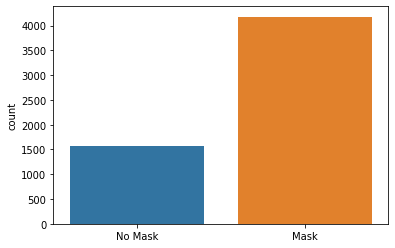

In [12]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

The visualization above tells us that the **number of mask images> Number of images without a mask**, so this is an unbalanced dataset. But since we’re using a pre-trained SSD model, which is trained to detect unmasked faces, this imbalance wouldn’t matter much.

But let’s reshape the data before training a neural network:

In [13]:
X = []
Y = []

for features,label in data:
    X.append(features)
    Y.append(label)

In [14]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

The next step is to train a Neural Network

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [16]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)

In [18]:
datagen.fit(xtrain)

In [19]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
143/143 [==============================] - 66s 237ms/step - loss: 0.4196 - accuracy: 0.8334 - val_loss: 0.2382 - val_accuracy: 0.9000
Epoch 2/50
143/143 [==============================] - 30s 206ms/step - loss: 0.3102 - accuracy: 0.8618 - val_loss: 0.2563 - val_accuracy: 0.8991
Epoch 3/50
143/143 [==============================] - 30s 206ms/step - loss: 0.2767 - accuracy: 0.8934 - val_loss: 0.1974 - val_accuracy: 0.9313
Epoch 4/50
143/143 [==============================] - 30s 207ms/step - loss: 0.2996 - accuracy: 0.8719 - val_loss: 0.2197 - val_accuracy: 0.9070
Epoch 5/50
143/143 [==============================] - 30s 206ms/step - loss: 0.2833 - accuracy: 0.8824 - val_loss: 0.1947 - val_accuracy: 0.9217
Epoch 6/50
143/143 [==============================] - 29s 205ms/step - loss: 0.2679 - accuracy: 0.8848 - val_loss: 0.1808 - val_accuracy: 0.9304
Epoch 7/50
143/143 [==============================] - 29s 205ms/step - loss: 0.2488 - accuracy: 0.8999 - val_loss: 0.1769 - val_ac

### Testing The Model

The test dataset contains 1698 images and to evaluate the model we
took a handful of images from this dataset as there are no face tags in the dataset:

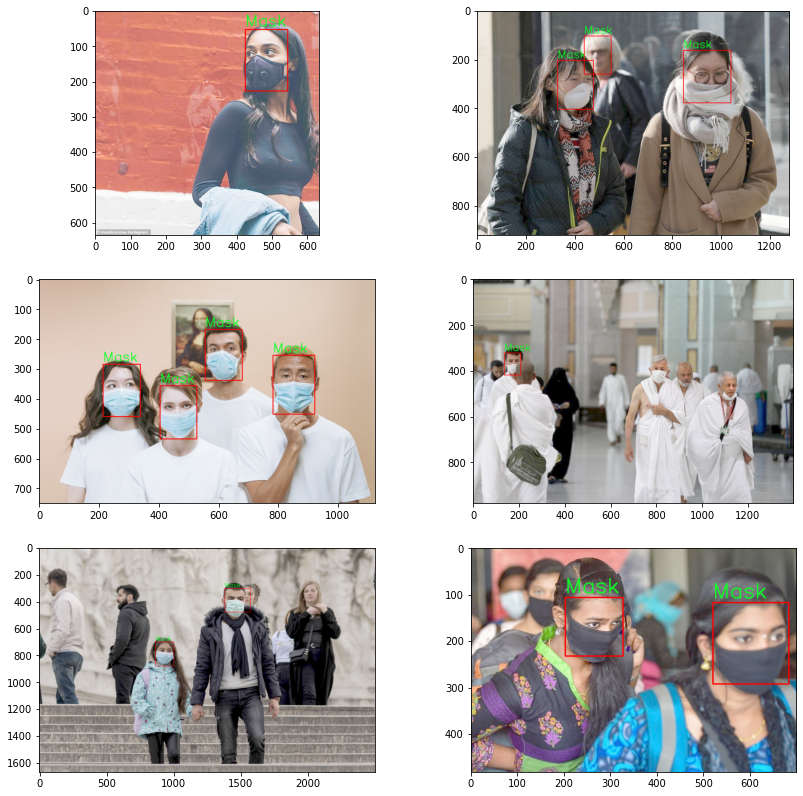

In [20]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}

for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

By analyzing the output above, we can observe that the whole system works well for faces that have spatial dominance. But fails in the case of images where the faces are small and take up less space in the overall image.

For best results, different image preprocessing techniques can be used, or the confidence threshold can be kept lower, or one can try different blob sizes.